In [32]:
import os.path as op
import mne
from scripts.processing.library.config import study_path, subjects_dir, N_JOBS, spacing
%matplotlib inline

# The paths to Freesurfer reconstructions
subject = "sub002" 
subjects_dir = op.join(study_path, 'subjects')
print(subjects_dir)


/Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects


## <font color=" #e533ff ">Compute and visualize BEM surfaces</font>

Using surface: /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/bem/inner_skull.surf
Using surface: /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/bem/outer_skull.surf
Using surface: /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/bem/outer_skin.surf


/Users/ricklicona/PycharmProjects/RExam/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


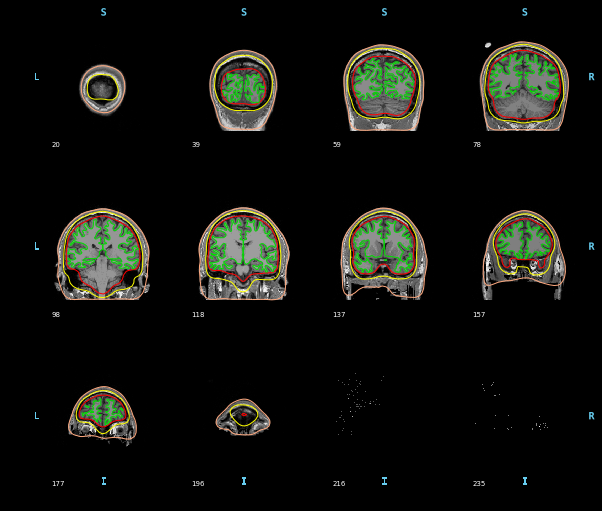

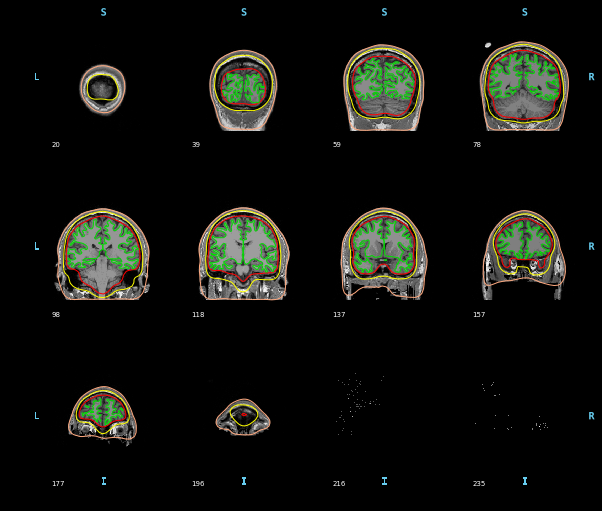

In [29]:
mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir,
                 brain_surfaces='white', orientation='coronal')

##  <font color=" #e533ff ">Visualizing the coregistration</font>

In [9]:
# the raw file containing the channel location + types
raw_fname = "/Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/ds117/sub002/sub002_highpass-NoneHz-ave.fif"
info = mne.io.read_info(raw_fname)
trans = "/Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/ds117/sub002/MEG/sub002-trans.fif"

    Read a total of 1 projection items:
        Average EEG reference (1 x 70) active


In [ ]:
#Mayavi
from mayavi import mlab 
mlab.options.offscreen = True
mlab.init_notebook() 

# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.

corr = mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
                       meg=['helmet', 'sensors'], subjects_dir=subjects_dir,
                       surfaces='head-dense')
corr

## <font color="green"> COMPUTE SOURCE SPACE</font>

In [3]:
src = mne.setup_source_space(subject, spacing='oct6', add_dist='patch',
                             subjects_dir=subjects_dir)
print(src)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects
Subject      = sub002
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/surf/lh.white...
Mapping lh sub002 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/139132 selected to source space (oct = 6)

Loading /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/surf/rh.white...
Mapping rh sub002 -> oct (6) ...
    Triangle neighbors

Using surface: /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/bem/inner_skull.surf
Using surface: /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/bem/outer_skull.surf
Using surface: /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/bem/outer_skin.surf


/Users/ricklicona/PycharmProjects/RExam/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


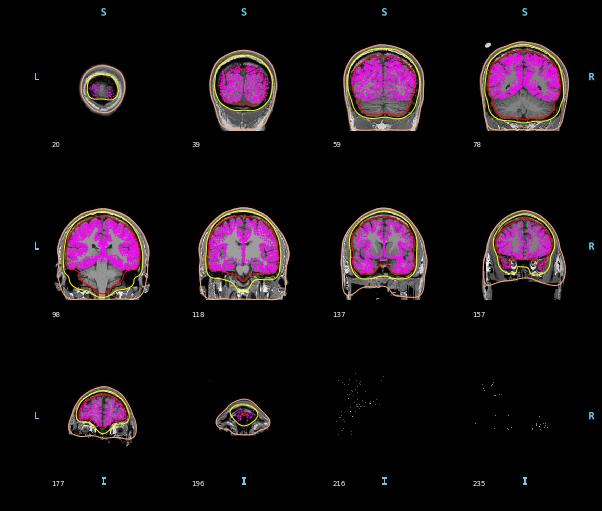

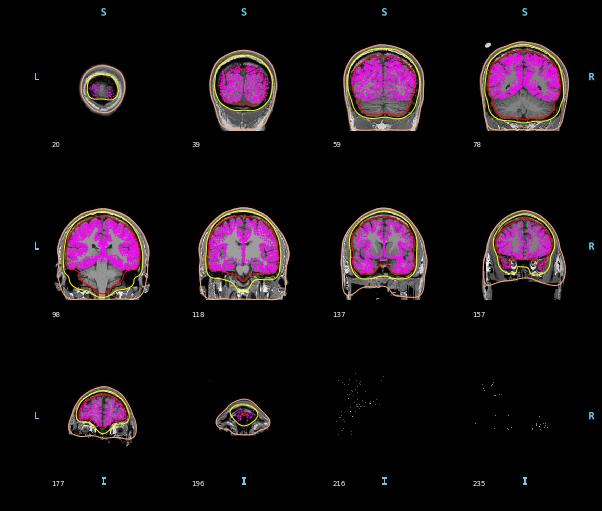

In [30]:
mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir,
                 brain_surfaces='white', src=src, orientation='coronal')

## <font color="green">BEM ESTIMATION</font>

Note that the BEM does not involve any use of the trans file. The BEM only depends on the head geometry and conductivities. It is therefore independent from the MEG data and the head position.

## - Bem surfaces

In [26]:
#conductivity = (0.3,)  # for single layer
conductivity = (0.3, 0.006, 0.3)  # for three layer (EEG)

# BEM MODEL FILE
fname_bem_surfaces = op.join(subjects_dir, subject, 'bem',
                                     '%s-5120-bem-3layers.fif' % (subject))
# BEM SOLUTION FILE
fname_bem = op.join(subjects_dir, subject, 'bem', 
                    '%s-5120-bem-sol-3layers.fif' % (subject))
# CHECK UBICATION OF THE FILES

print(fname_bem_surfaces)
print(fname_bem)

/Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/bem/sub002-5120-bem-3layers.fif
/Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/scripts/processing/library/../../../subjects/sub002/bem/sub002-5120-bem-sol-3layers.fif


## - Write BEM surfaces

In [27]:
model = mne.make_bem_model(subject=subject, ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)

mne.write_bem_surfaces(fname_bem_surfaces, model)

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
outer skin  CM is  -1.62 -13.44  -3.77 mm
outer skull CM is  -1.25 -19.59   0.91 mm
inner skull CM is  -1.24 -19.54   0.29 mm
Checking that outer skull surface is inside outer skin  surface...
Checking that inner skull surface is inside outer skull surface...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    2.7 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    3.8 mm
Surfaces passed the basic topology checks.
Complete.



## - Write BEM solution

In [28]:
bem_model = mne.read_bem_surfaces(fname_bem_surfaces)
bem = mne.make_bem_solution(bem_model)
mne.write_bem_solution(fname_bem, bem)

    3 BEM surfaces found
    Reading a surface...
[done]
    Reading a surface...
[done]
    Reading a surface...
[done]
    3 BEM surfaces read
Approximation method : Linear collocation

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        outer skin  (2562) -> outer skin  (2562) ...
        outer skin  (2562) -> outer skull (2562) ...
        outer skin  (2562) -> inner skull (2562) ...
        outer skull (2562) -> outer skin  (2562) ...
        outer skull (2562) -> outer skull (2562) ...
        outer skull (2562) -> inner skull (2562) ...
        inner skull (2562) -> outer skin  (2562) ...
        inner skull (2562) -> outer skull (2562) ...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
IP approach required...
    Matrix coefficients (homog)...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix (homog)...
    Modify the original solu

## <font color="green"> FORWARD SOLUTION </font>

In [10]:
fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem,
                                meg=False, eeg=True, mindist=5.0, n_jobs=1,
                                verbose=True)
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=139132, n_used=4098>, <surface (rh), n_vertices=139806, n_used=4098>] MRI (surface RAS) coords, subject 'sub002', ~26.7 MB>
MRI -> head transform : /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/ds117/sub002/MEG/sub002-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999327 -0.017528 -0.032207       4.37 mm
     0.028260  0.927852  0.371877      35.02 mm
     0.023365 -0.372537  0.927723      46.39 mm
     0.000000  0.000000  0.000000       1.00

Read  70 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of Conduct

In [11]:
print(f'Before: {src}')
print(f'After:  {fwd["src"]}')

Before: <SourceSpaces: [<surface (lh), n_vertices=139132, n_used=4098>, <surface (rh), n_vertices=139806, n_used=4098>] MRI (surface RAS) coords, subject 'sub002', ~26.7 MB>
After:  <SourceSpaces: [<surface (lh), n_vertices=139132, n_used=3589>, <surface (rh), n_vertices=139806, n_used=3622>] head coords, subject 'sub002', ~26.7 MB>


We can explore the content of fwd to access the numpy array that contains the gain matrix.

In [ ]:
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

To extract the numpy array containing the forward operator corresponding to the source space fwd['src'] with cortical orientation constraint we can use the following:

In [ ]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)



To save to disk a forward solution you can use mne.write_forward_solution() and to read it back from disk mne.read_forward_solution(). Don’t forget that FIF files containing forward solution should end with -fwd.fif.

To get a fixed-orientation forward solution, use mne.convert_forward_solution() to convert the free-orientation solution to (surface-oriented) fixed orientation.

# COMPARACIÓN (HIPOTESIS DE MEG Y EEG ARCHIVOS .FIF) "FORWARD SOLUTION"

In [13]:
bem2 = "/Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/subjects/sub002/bem/sub002-5120-bem-sol.fif"
src2 = "/Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/subjects/sub002/bem/sub002-oct6-src.fif"
fwd2 = mne.make_forward_solution(info, trans=trans, src=src2, bem=bem2,
                                meg=False, eeg=True, mindist=5.0, n_jobs=1,
                                verbose=True)
print(fwd2)

Source space          : /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/subjects/sub002/bem/sub002-oct6-src.fif
MRI -> head transform : /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/ds117/sub002/MEG/sub002-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/subjects/sub002/bem/sub002-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/subjects/sub002/bem/sub002-oct6-src.fif...
Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999327 -0.017528 -0.032207       4.37 mm
     0.028260  0.927852  0.371877      35.02 mm
     0.023365 -0.372537  0.927723      46.39 mm
     0.000000  0.000000  0.000000       1.00

Read  70 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in 

RuntimeError: Cannot use a homogeneous (1-layer BEM) model for EEG forward calculations, consider using a 3-layer BEM instead

###  <font color="blue"> CONFIRMADO, EL ARCHIVO BEM_SOL.FIF ES SOLAMENTE PARA 1-LAYER BEM, ES DECIR, PARA MEG!!</font>

## <font color='red'> Pendiente: POSIBLE SOLUCIÓN: SEGUIR EL PIPELINE DE AQUI CON CONDUCTIVITY DE 3 CAPAS (EEG) Y LA SOLUCIÓN GENERADA, HAY QUE CARGARLA EN MAKE_FORWARD. ESTO ES LO PROXIMO A REALIZAR HIJO DE PERRA. bar</font> 

Probaremos el **modelo** generado por GITHUB project, es decir, el llamado: sub002-5120-bem.fif

In [14]:
model = "/Users/ricklicona/Documents/GitHub/mne-biomag-group-demo/subjects/sub002/bem/sub002-5120-bem.fif"
bem = mne.make_bem_solution(model)

Approximation method : Linear collocation

Loading surfaces...
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read
Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


###  <font color="blue"> CONFIRMADO, TAMBIÉN EL ARCHIVO MODEL ES PARA UNA MALDITA SURFACE!!</font>